# **DSA 2040 US 2025 End Semester Practical Exam**
**Mark Chweya – ID: [Your ID Last 3 Digits]**
---
## Section 1 – Data Warehousing (50 Marks)

### Task 1 – Data Warehouse Design (15 Marks)
**a) Star Schema Diagram**

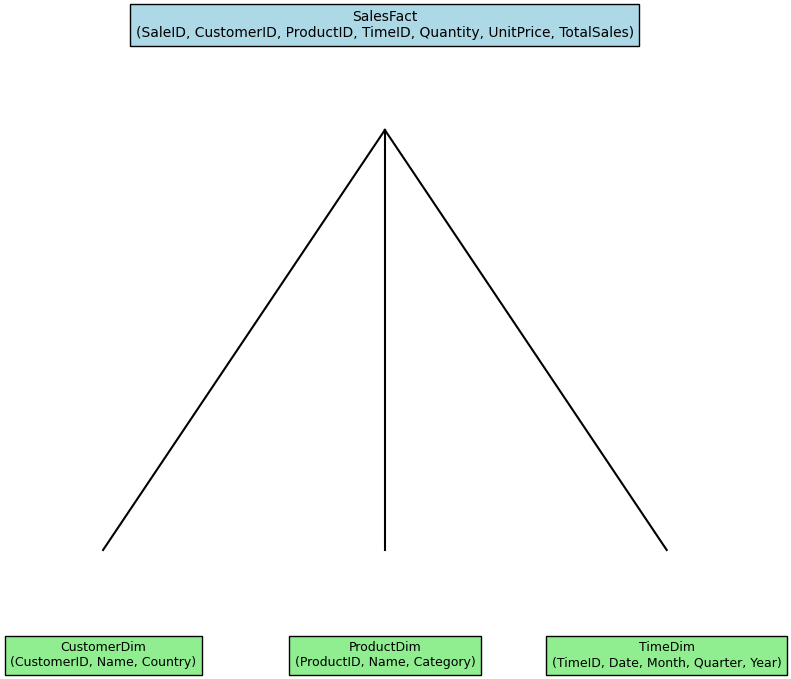

In [1]:
# TODO: Generate star schema diagram using matplotlib or graphviz

import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Main fact table
ax.text(0.5, 0.9, "SalesFact\n(SaleID, CustomerID, ProductID, TimeID, Quantity, UnitPrice, TotalSales)",
        ha="center", va="center", fontsize=10, bbox=dict(facecolor='lightblue', edgecolor='black'))

# Dimension tables
ax.text(0.2, 0.6, "CustomerDim\n(CustomerID, Name, Country)",
        ha="center", va="center", fontsize=9, bbox=dict(facecolor='lightgreen', edgecolor='black'))

ax.text(0.5, 0.6, "ProductDim\n(ProductID, Name, Category)",
        ha="center", va="center", fontsize=9, bbox=dict(facecolor='lightgreen', edgecolor='black'))

ax.text(0.8, 0.6, "TimeDim\n(TimeID, Date, Month, Quarter, Year)",
        ha="center", va="center", fontsize=9, bbox=dict(facecolor='lightgreen', edgecolor='black'))

# Connect dimensions to fact table
ax.plot([0.5, 0.2], [0.85, 0.65], 'k-')
ax.plot([0.5, 0.5], [0.85, 0.65], 'k-')
ax.plot([0.5, 0.8], [0.85, 0.65], 'k-')

# Hide axes
ax.axis('off')

# Save and show
plt.savefig("star_schema.png", bbox_inches="tight")
plt.show()


**b) Why Star Schema over Snowflake Schema?**

We use a Star Schema because it’s faster and easier to work with. All the details about things like customers, products, and time are kept in single, easy-to-read tables. That way, reports run quickly and don’t need a lot of complicated joins.

A Snowflake Schema breaks those tables into smaller pieces to save space, but that makes the structure more complex and slows down queries. For this retail warehouse, speed and simplicity are more important than saving a bit of storage.

In [2]:
import sqlite3

schema_sql = '''
CREATE TABLE CustomerDim (
    CustomerID INTEGER PRIMARY KEY,
    CustomerName TEXT NOT NULL,
    Country TEXT NOT NULL
);

CREATE TABLE ProductDim (
    ProductID INTEGER PRIMARY KEY,
    ProductName TEXT NOT NULL,
    Category TEXT NOT NULL
);

CREATE TABLE TimeDim (
    TimeID INTEGER PRIMARY KEY,
    Date DATE NOT NULL,
    Month INTEGER NOT NULL,
    Quarter INTEGER NOT NULL,
    Year INTEGER NOT NULL
);

CREATE TABLE SalesFact (
    SaleID INTEGER PRIMARY KEY AUTOINCREMENT,
    CustomerID INTEGER NOT NULL,
    ProductID INTEGER NOT NULL,
    TimeID INTEGER NOT NULL,
    Quantity INTEGER NOT NULL,
    UnitPrice REAL NOT NULL,
    TotalSales REAL NOT NULL,
    FOREIGN KEY (CustomerID) REFERENCES CustomerDim(CustomerID),
    FOREIGN KEY (ProductID) REFERENCES ProductDim(ProductID),
    FOREIGN KEY (TimeID) REFERENCES TimeDim(TimeID)
);
'''

print(schema_sql)



CREATE TABLE CustomerDim (
    CustomerID INTEGER PRIMARY KEY,
    CustomerName TEXT NOT NULL,
    Country TEXT NOT NULL
);

CREATE TABLE ProductDim (
    ProductID INTEGER PRIMARY KEY,
    ProductName TEXT NOT NULL,
    Category TEXT NOT NULL
);

CREATE TABLE TimeDim (
    TimeID INTEGER PRIMARY KEY,
    Date DATE NOT NULL,
    Month INTEGER NOT NULL,
    Quarter INTEGER NOT NULL,
    Year INTEGER NOT NULL
);

CREATE TABLE SalesFact (
    SaleID INTEGER PRIMARY KEY AUTOINCREMENT,
    CustomerID INTEGER NOT NULL,
    ProductID INTEGER NOT NULL,
    TimeID INTEGER NOT NULL,
    Quantity INTEGER NOT NULL,
    UnitPrice REAL NOT NULL,
    TotalSales REAL NOT NULL,
    FOREIGN KEY (CustomerID) REFERENCES CustomerDim(CustomerID),
    FOREIGN KEY (ProductID) REFERENCES ProductDim(ProductID),
    FOREIGN KEY (TimeID) REFERENCES TimeDim(TimeID)
);



### Task 2 – ETL Process Implementation (20 Marks)

In [3]:
import pandas as pd
import numpy as np
from faker import Faker
import pandas as pd
import numpy as np
import sqlite3


faker = Faker()
np.random.seed(42)

# Define possible countries and products
countries = ["UK", "USA", "Germany", "France", "Kenya"]
products = [
    ("Laptop", "Electronics"),
    ("Shirt", "Clothing"),
    ("Phone", "Electronics"),
    ("Shoes", "Clothing"),
    ("Headphones", "Electronics"),
    ("Watch", "Accessories"),
    ("Bag", "Accessories"),
    ("Tablet", "Electronics"),
]

data = []
for _ in range(1000):
    invoice_no = faker.uuid4()
    product_name, category = faker.random_element(elements=products)
    quantity = faker.random_int(min=1, max=50)
    unit_price = round(faker.random.uniform(1, 100), 2)
    invoice_date = faker.date_between(start_date="-2y", end_date="today")
    customer_id = faker.random_int(min=1, max=100)
    customer_name = faker.name()
    country = faker.random_element(elements=countries)

    data.append([
        invoice_no, product_name, category, quantity,
        invoice_date, unit_price, customer_id, customer_name, country
    ])

# Create DataFrame
df = pd.DataFrame(data, columns=[
    "InvoiceNo", "ProductName", "Category", "Quantity", "InvoiceDate",
    "UnitPrice", "CustomerID", "CustomerName", "Country"
])

# Preview first 5 rows
df.head()


,InvoiceNo,ProductName,Category,Quantity,InvoiceDate,UnitPrice,CustomerID,CustomerName,Country
0,312e9dc5-015d-4f37-99b1-f61784c4ec60,Shirt,Clothing,26,2024-12-22,20.35,99,Kathy Graves,UK
1,a44e21f3-902a-4cde-b50b-d576e4449403,Headphones,Electronics,10,2025-06-18,33.11,100,Scott Martin,France
2,25e0cd48-575e-4d03-a460-ba845fee3675,Shirt,Clothing,28,2025-04-14,62.40,87,Todd Hayes,France
3,688072bc-6a8b-4441-b545-bc58d12a5edc,Phone,Electronics,11,2025-08-11,68.88,32,Joseph Nguyen,France
4,295f9927-725d-43a3-abab-83b1d7dd6bf8,Laptop,Electronics,30,2024-12-27,57.02,3,Troy Thomas,USA


In [4]:
# Step 2: Transform – Add TotalSales, summaries, filtering, outlier removal

# Step 2: Transformation

# Ensure InvoiceDate is a datetime object
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# 1. Add TotalSales column
df["TotalSales"] = df["Quantity"] * df["UnitPrice"]

# 2. Customer summary: total purchases & country
customer_summary = (
    df.groupby(["CustomerID", "CustomerName", "Country"])
      .agg(TotalPurchases=("TotalSales", "sum"),
           TotalQuantity=("Quantity", "sum"),
           NumTransactions=("InvoiceNo", "nunique"))
      .reset_index()
)

# 3. Filter for sales in the last year (assuming current date = 12 Aug 2025)
cutoff_date = pd.Timestamp("2024-08-12")
df_last_year = df[df["InvoiceDate"] >= cutoff_date]

# 4. Remove outliers (Quantity < 0, UnitPrice <= 0)
df_last_year = df_last_year[(df_last_year["Quantity"] > 0) & (df_last_year["UnitPrice"] > 0)]

# Logging: number of rows after each step
print("Original dataset rows:", len(df))
print("After last year filter:", len(df_last_year))
print("Customer summary rows:", len(customer_summary))

# Preview transformed dataset
df_last_year.head()


Original dataset rows: 1000
After last year filter: 520
Customer summary rows: 1000


,InvoiceNo,ProductName,Category,Quantity,InvoiceDate,UnitPrice,CustomerID,CustomerName,Country,TotalSales
0,312e9dc5-015d-4f37-99b1-f61784c4ec60,Shirt,Clothing,26,2024-12-22,20.35,99,Kathy Graves,UK,529.10
1,a44e21f3-902a-4cde-b50b-d576e4449403,Headphones,Electronics,10,2025-06-18,33.11,100,Scott Martin,France,331.10
2,25e0cd48-575e-4d03-a460-ba845fee3675,Shirt,Clothing,28,2025-04-14,62.40,87,Todd Hayes,France,1747.20
3,688072bc-6a8b-4441-b545-bc58d12a5edc,Phone,Electronics,11,2025-08-11,68.88,32,Joseph Nguyen,France,757.68
4,295f9927-725d-43a3-abab-83b1d7dd6bf8,Laptop,Electronics,30,2024-12-27,57.02,3,Troy Thomas,USA,1710.60


In [5]:
# Step 3: Load – Save into SQLite retail_dw.db with fact and dimension tables

import sqlite3

# Connect to (or create) the SQLite database
conn = sqlite3.connect("retail_dw.db")

# Create dimension tables from the transformed data
customer_dim = df_last_year[["CustomerID", "CustomerName", "Country"]].drop_duplicates()

# Assign ProductID to each product-category combination
product_dim = df_last_year[["ProductName", "Category"]].drop_duplicates().reset_index(drop=True)
product_dim["ProductID"] = product_dim.index + 1

# Create time dimension
time_dim = pd.DataFrame({"Date": df_last_year["InvoiceDate"].drop_duplicates()}).reset_index(drop=True)
time_dim["TimeID"] = time_dim.index + 1
time_dim["Month"] = time_dim["Date"].dt.month
time_dim["Quarter"] = time_dim["Date"].dt.quarter
time_dim["Year"] = time_dim["Date"].dt.year

# Merge to get IDs for fact table
fact_df = df_last_year.merge(product_dim, on=["ProductName", "Category"], how="left")
fact_df = fact_df.merge(time_dim, left_on="InvoiceDate", right_on="Date", how="left")

sales_fact = fact_df[[
    "CustomerID", "ProductID", "TimeID", "Quantity", "UnitPrice", "TotalSales"
]]

# Save all tables into SQLite
customer_dim.to_sql("CustomerDim", conn, if_exists="replace", index=False)
product_dim[["ProductID", "ProductName", "Category"]].to_sql("ProductDim", conn, if_exists="replace", index=False)
time_dim[["TimeID", "Date", "Month", "Quarter", "Year"]].to_sql("TimeDim", conn, if_exists="replace", index=False)
sales_fact.to_sql("SalesFact", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

print(" Data loaded into retail_dw.db (CustomerDim, ProductDim, TimeDim, SalesFact)")


 Data loaded into retail_dw.db (CustomerDim, ProductDim, TimeDim, SalesFact)


In [6]:
# Step 4: ETL Function – logs rows processed at each stage



def run_etl(db_name="retail_dw.db", rows=1000, seed=42):
    faker = Faker()
    np.random.seed(seed)

    print("Starting ETL process...")

    # ----------------- Extraction -----------------
    countries = ["UK", "USA", "Germany", "France", "Kenya"]
    products = [
        ("Laptop", "Electronics"),
        ("Shirt", "Clothing"),
        ("Phone", "Electronics"),
        ("Shoes", "Clothing"),
        ("Headphones", "Electronics"),
        ("Watch", "Accessories"),
        ("Bag", "Accessories"),
        ("Tablet", "Electronics"),
    ]

    data = []
    for _ in range(rows):
        invoice_no = faker.uuid4()
        product_name, category = faker.random_element(elements=products)
        quantity = faker.random_int(min=1, max=50)
        unit_price = round(faker.random.uniform(1, 100), 2)
        invoice_date = faker.date_between(start_date="-2y", end_date="today")
        customer_id = faker.random_int(min=1, max=100)
        customer_name = faker.name()
        country = faker.random_element(elements=countries)

        data.append([
            invoice_no, product_name, category, quantity,
            invoice_date, unit_price, customer_id, customer_name, country
        ])

    df = pd.DataFrame(data, columns=[
        "InvoiceNo", "ProductName", "Category", "Quantity", "InvoiceDate",
        "UnitPrice", "CustomerID", "CustomerName", "Country"
    ])
    print(f"Extraction complete: {len(df)} rows generated.")

    # ----------------- Transformation -----------------
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    df["TotalSales"] = df["Quantity"] * df["UnitPrice"]

    # Remove outliers
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
    print(f"After outlier removal: {len(df)} rows remain.")

    # Filter last year sales (current date = 12 Aug 2025)
    cutoff_date = pd.Timestamp("2024-08-12")
    df_last_year = df[df["InvoiceDate"] >= cutoff_date]
    print(f"After last year filter: {len(df_last_year)} rows remain.")

    # ----------------- Loading -----------------
    conn = sqlite3.connect(db_name)

    customer_dim = df_last_year[["CustomerID", "CustomerName", "Country"]].drop_duplicates()

    product_dim = df_last_year[["ProductName", "Category"]].drop_duplicates().reset_index(drop=True)
    product_dim["ProductID"] = product_dim.index + 1

    time_dim = pd.DataFrame({"Date": df_last_year["InvoiceDate"].drop_duplicates()}).reset_index(drop=True)
    time_dim["TimeID"] = time_dim.index + 1
    time_dim["Month"] = time_dim["Date"].dt.month
    time_dim["Quarter"] = time_dim["Date"].dt.quarter
    time_dim["Year"] = time_dim["Date"].dt.year

    fact_df = df_last_year.merge(product_dim, on=["ProductName", "Category"], how="left")
    fact_df = fact_df.merge(time_dim, left_on="InvoiceDate", right_on="Date", how="left")
    sales_fact = fact_df[[
        "CustomerID", "ProductID", "TimeID", "Quantity", "UnitPrice", "TotalSales"
    ]]

    customer_dim.to_sql("CustomerDim", conn, if_exists="replace", index=False)
    product_dim[["ProductID", "ProductName", "Category"]].to_sql("ProductDim", conn, if_exists="replace", index=False)
    time_dim[["TimeID", "Date", "Month", "Quarter", "Year"]].to_sql("TimeDim", conn, if_exists="replace", index=False)
    sales_fact.to_sql("SalesFact", conn, if_exists="replace", index=False)

    conn.commit()
    conn.close()

    print("Data loaded into SQLite database.")
    print(f"CustomerDim: {len(customer_dim)} rows")
    print(f"ProductDim: {len(product_dim)} rows")
    print(f"TimeDim: {len(time_dim)} rows")
    print(f"SalesFact: {len(sales_fact)} rows")
    print("ETL process complete.")

# Run the ETL
run_etl()


Starting ETL process...
Extraction complete: 1000 rows generated.
After outlier removal: 1000 rows remain.
After last year filter: 500 rows remain.
Data loaded into SQLite database.
CustomerDim: 500 rows
ProductDim: 8 rows
TimeDim: 272 rows
SalesFact: 500 rows
ETL process complete.


### Task 3 – OLAP Queries & Analysis (15 Marks)

Roll-up: Sales by Country and Quarter
    Country  Quarter  TotalSales
0    France        1   266229.71
1    France        2   140503.98
2    France        3   217126.82
3    France        4   256137.07
4   Germany        1   269634.62
5   Germany        2   158317.50
6   Germany        3   318735.54
7   Germany        4   205782.20
8     Kenya        1   188398.06
9     Kenya        2   120094.48
10    Kenya        3   232930.53
11    Kenya        4   206457.49
12       UK        1   218134.21
13       UK        2   156261.56
14       UK        3   221318.55
15       UK        4   234420.71
16      USA        1   231745.86
17      USA        2   149347.67
18      USA        3   216404.08
19      USA        4   191398.60

Drill-down: UK Sales by Month
    Year  Month  TotalSales
0   2024      8    38496.78
1   2024      9    90009.67
2   2024     10    67367.94
3   2024     11    74101.18
4   2024     12    92951.59
5   2025      1    61508.15
6   2025      2    61782.59
7   2025      

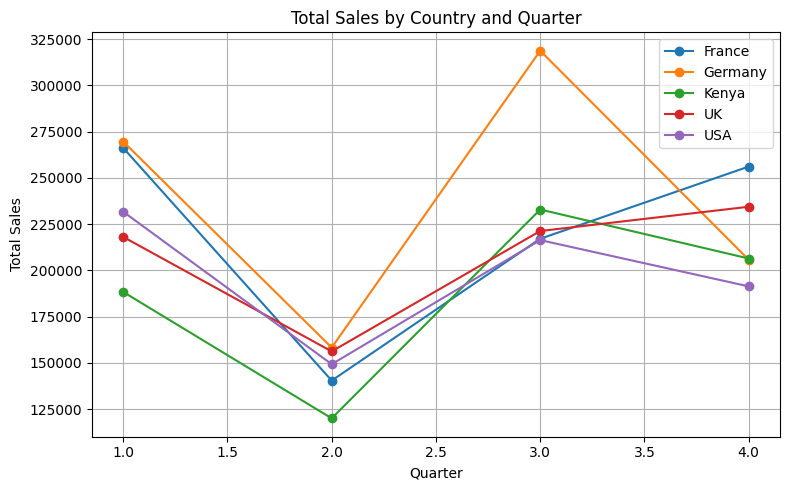

In [7]:
# SQL queries: Roll-up, Drill-down, Slice

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to database
conn = sqlite3.connect("retail_dw.db")

# ------------------- Roll-up: Total sales by country and quarter -------------------
query_rollup = """
SELECT c.Country, t.Quarter, SUM(f.TotalSales) AS TotalSales
FROM SalesFact f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.TimeID = t.TimeID
GROUP BY c.Country, t.Quarter
ORDER BY c.Country, t.Quarter;
"""
df_rollup = pd.read_sql_query(query_rollup, conn)
print("Roll-up: Sales by Country and Quarter")
print(df_rollup)

# ------------------- Drill-down: Sales for UK by month -------------------
query_drilldown = """
SELECT t.Year, t.Month, SUM(f.TotalSales) AS TotalSales
FROM SalesFact f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.TimeID = t.TimeID
WHERE c.Country = 'UK'
GROUP BY t.Year, t.Month
ORDER BY t.Year, t.Month;
"""
df_drilldown = pd.read_sql_query(query_drilldown, conn)
print("\nDrill-down: UK Sales by Month")
print(df_drilldown)

# ------------------- Slice: Total sales for Electronics category -------------------
query_slice = """
SELECT SUM(f.TotalSales) AS TotalSales
FROM SalesFact f
JOIN ProductDim p ON f.ProductID = p.ProductID
WHERE p.Category = 'Electronics';
"""
df_slice = pd.read_sql_query(query_slice, conn)
print("\nSlice: Total Sales for Electronics Category")
print(df_slice)

# ------------------- Visualization: Roll-up results -------------------
plt.figure(figsize=(8,5))
for country in df_rollup["Country"].unique():
    subset = df_rollup[df_rollup["Country"] == country]
    plt.plot(subset["Quarter"], subset["TotalSales"], marker="o", label=country)

plt.title("Total Sales by Country and Quarter")
plt.xlabel("Quarter")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rollup_sales_chart.png")
plt.show()

conn.close()


<Figure size 800x500 with 0 Axes>

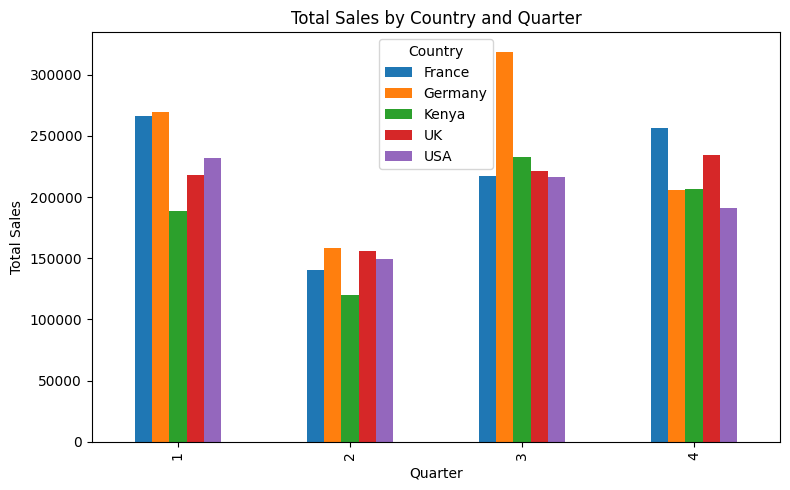

In [8]:
# Visualization of one query using matplotlib

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect("retail_dw.db")

# Run Roll-up query: Sales by Country and Quarter
query_rollup = """
SELECT c.Country, t.Quarter, SUM(f.TotalSales) AS TotalSales
FROM SalesFact f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.TimeID = t.TimeID
GROUP BY c.Country, t.Quarter
ORDER BY c.Country, t.Quarter;
"""
df_rollup = pd.read_sql_query(query_rollup, conn)
conn.close()

# Pivot for plotting (Quarters as X-axis, Countries as series)
pivot_df = df_rollup.pivot(index="Quarter", columns="Country", values="TotalSales")

# Plot
plt.figure(figsize=(8,5))
pivot_df.plot(kind="bar", figsize=(8,5))
plt.title("Total Sales by Country and Quarter")
plt.xlabel("Quarter")
plt.ylabel("Total Sales")
plt.legend(title="Country")
plt.tight_layout()

# Save visualization for GitHub submission
plt.savefig("sales_by_country_quarter.png")

# Show the plot
plt.show()


**Analysis Report (200–300 words)**
_Your analysis text here_

## Section 2 – Data Mining (50 Marks)

### Task 1 – Data Preprocessing & Exploration (15 Marks)

In [9]:
# Load Iris dataset
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
df = iris.frame
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [10]:
# Preprocessing: Handle missing, Min-Max scale, encode class

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the Iris dataset as a DataFrame
iris = load_iris(as_frame=True)
df_iris = iris.frame.copy()

# Step 1: Handle missing values (for demonstration, we'll artificially insert some)
# In the real dataset, there are no missing values, but we demonstrate the check
print("Missing values before handling:\n", df_iris.isnull().sum())

# Fill missing numeric values with the column mean (if any were missing)
for col in df_iris.columns[:-1]:
    df_iris[col].fillna(df_iris[col].mean(), inplace=True)

# Step 2: Min-Max scaling for features
scaler = MinMaxScaler()
df_iris.iloc[:, :-1] = scaler.fit_transform(df_iris.iloc[:, :-1])

# Step 3: Encode the class label (target)
encoder = LabelEncoder()
df_iris["target"] = encoder.fit_transform(df_iris["target"])

print("\nAfter preprocessing:")
print(df_iris.head())


Missing values before handling:
 sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

After preprocessing:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0           0.222222          0.625000           0.067797          0.041667   
1           0.166667          0.416667           0.067797          0.041667   
2           0.111111          0.500000           0.050847          0.041667   
3           0.083333          0.458333           0.084746          0.041667   
4           0.194444          0.666667           0.067797          0.041667   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


C:\Users\PC\AppData\Local\Temp\ipykernel_9484\3205083430.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_iris[col].fillna(df_iris[col].mean(), inplace=True)


Summary statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            0.428704          0.440556           0.467458   
std             0.230018          0.181611           0.299203   
min             0.000000          0.000000           0.000000   
25%             0.222222          0.333333           0.101695   
50%             0.416667          0.416667           0.567797   
75%             0.583333          0.541667           0.694915   
max             1.000000          1.000000           1.000000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           0.458056    1.000000  
std            0.317599    0.819232  
min            0.000000    0.000000  
25%            0.083333    0.000000  
50%            0.500000    1.000000  
75%            0.708333    2.000000  
max            1.000000    2.000000  


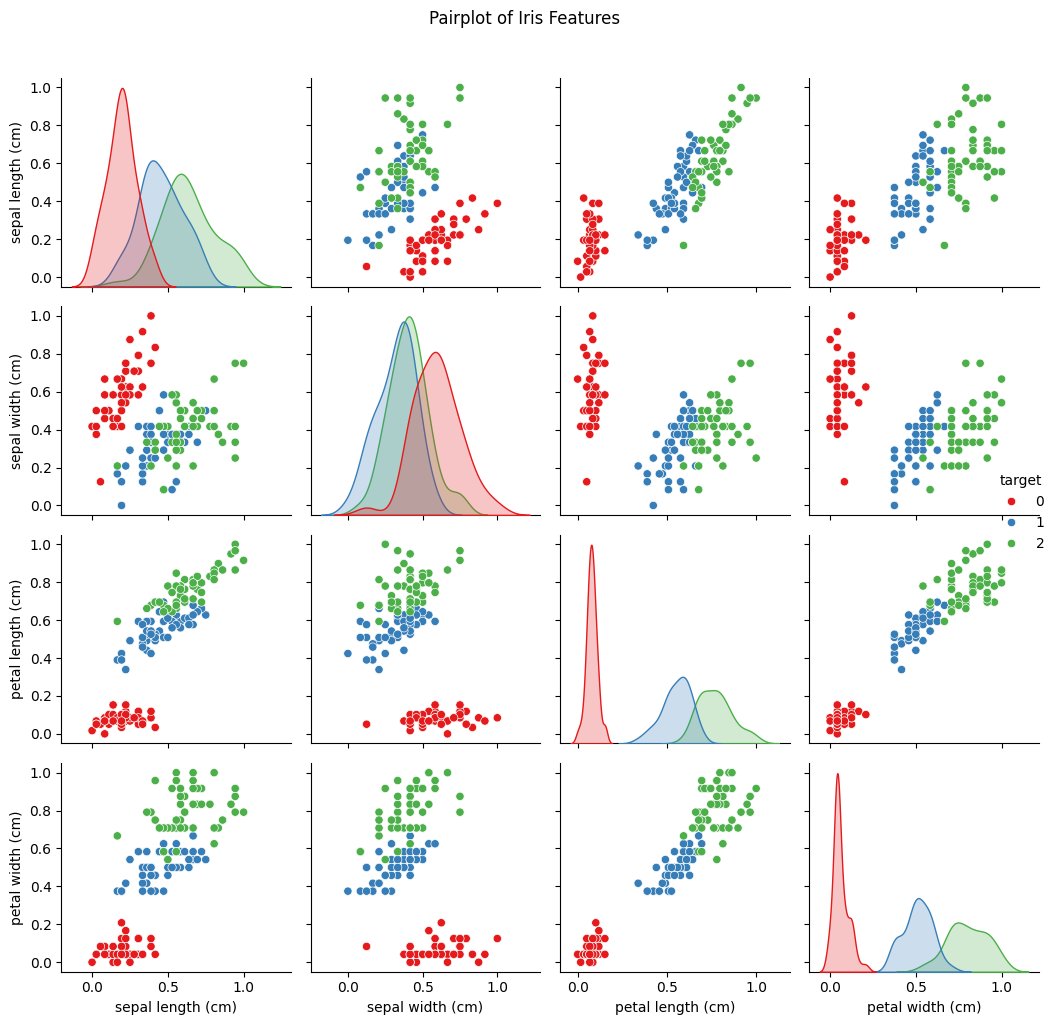

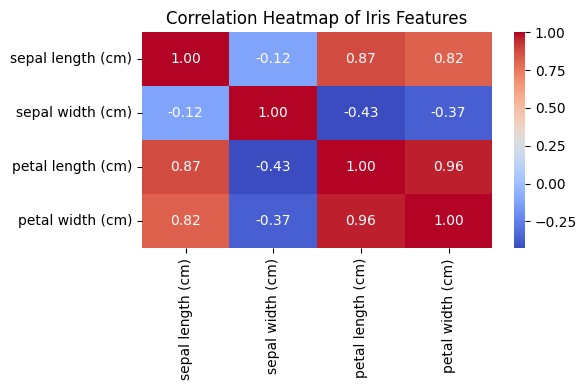

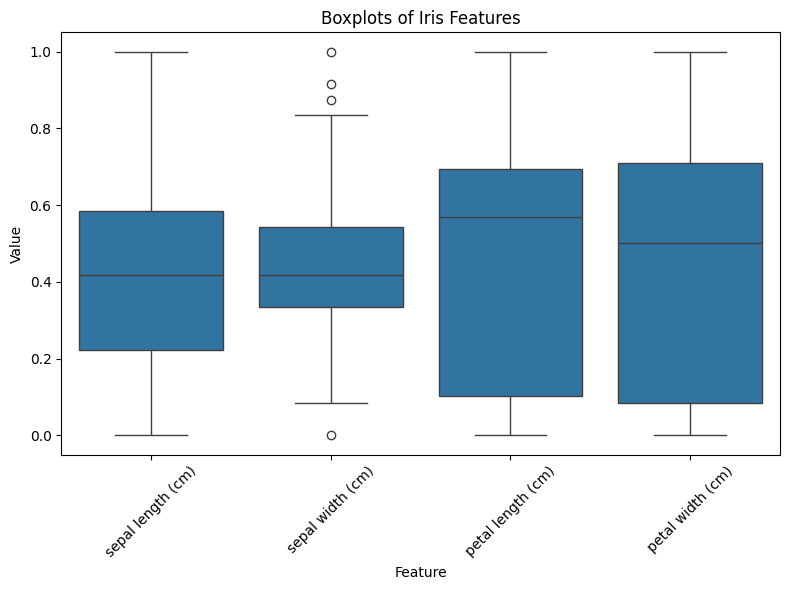

In [11]:
# Exploration: describe, pairplot, heatmap, boxplots

import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print("Summary statistics:")
print(df_iris.describe())

# Pairplot: Relationships between features
sns.pairplot(df_iris, hue="target", diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot of Iris Features", y=1.02)
plt.tight_layout()
plt.savefig("iris_pairplot.png")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
corr = df_iris.iloc[:, :-1].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Iris Features")
plt.tight_layout()
plt.savefig("iris_heatmap.png")
plt.show()

# Boxplots for outlier detection
plt.figure(figsize=(8,6))
df_melted = df_iris.melt(id_vars="target", var_name="Feature", value_name="Value")
sns.boxplot(x="Feature", y="Value", data=df_melted)
plt.title("Boxplots of Iris Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("iris_boxplots.png")
plt.show()


In [12]:
# Function to split data 80/20
from sklearn.model_selection import train_test_split

def split_data(df, target_col="target", test_size=0.2, random_state=42):
    """
    Splits dataset into training and testing sets (80/20 by default).

    Parameters:
        df (pd.DataFrame): DataFrame containing features and target.
        target_col (str): Name of target column.
        test_size (float): Proportion of data for test set.
        random_state (int): Seed for reproducibility.

    Returns:
        X_train, X_test, y_train, y_test
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

# Example usage
X_train, X_test, y_train, y_test = split_data(df_iris)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 120
Testing set size: 30


### Task 2 – Clustering (15 Marks)

In [13]:
# K-Means clustering k=3, compare with classes using ARI

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Apply K-Means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_train)

# Compare with actual classes using ARI
ari_score = adjusted_rand_score(y_train, kmeans_labels)

print(f"K-Means (k=3) Adjusted Rand Index: {ari_score:.4f}")

# Optional: View cluster centers
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
print("\nCluster Centers (scaled features):")
print(centers_df)


K-Means (k=3) Adjusted Rand Index: 0.7256

Cluster Centers (scaled features):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.190278          0.589583           0.080932          0.064583
1           0.438776          0.296769           0.574196          0.551020
2           0.718638          0.461022           0.805358          0.827957


K=2 → ARI Score: 0.5673
K=3 → ARI Score: 0.7256
K=4 → ARI Score: 0.6402


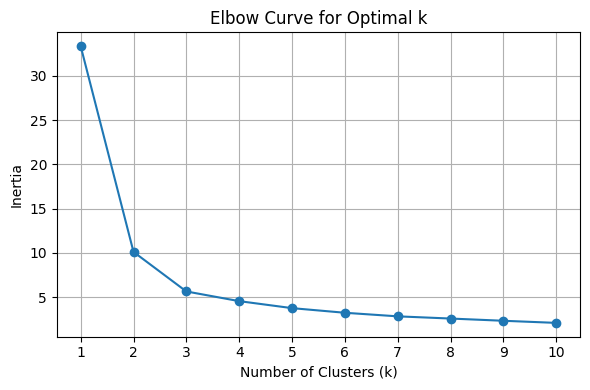

In [14]:
# Try k=2 and k=4, plot elbow curve
# Try k=2 and k=4
k_values = [2, 3, 4]
for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_train)
    ari_temp = adjusted_rand_score(y_train, labels_temp)
    print(f"K={k} → ARI Score: {ari_temp:.4f}")

# Elbow curve
inertia_values = []
k_range = range(1, 11)  # k from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_range, inertia_values, marker="o")
plt.title("Elbow Curve for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.savefig("kmeans_elbow_curve.png")
plt.show()


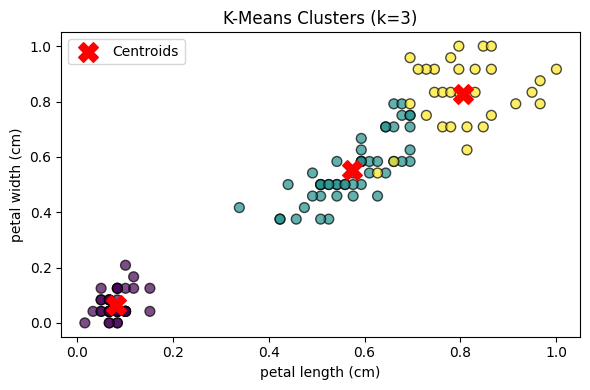

In [15]:
# Scatter plot clusters

# Re-run KMeans with k=3 for final visualization
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_train)

# Pick two features for visualization
feature_x = "petal length (cm)"
feature_y = "petal width (cm)"

plt.figure(figsize=(6, 4))
plt.scatter(
    X_train[feature_x],
    X_train[feature_y],
    c=cluster_labels,
    cmap="viridis",
    s=50,
    alpha=0.7,
    edgecolor="k"
)

# Plot cluster centers
centers = kmeans_final.cluster_centers_
plt.scatter(
    centers[:, X_train.columns.get_loc(feature_x)],
    centers[:, X_train.columns.get_loc(feature_y)],
    c="red",
    marker="X",
    s=200,
    label="Centroids"
)

plt.title("K-Means Clusters (k=3)")
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend()
plt.tight_layout()
plt.savefig("kmeans_clusters.png")
plt.show()


### Task 3 – Classification & Association Rule Mining (20 Marks)

Decision Tree Performance:
Accuracy : 0.9333
Precision: 0.9333
Recall   : 0.9333
F1 Score : 0.9333


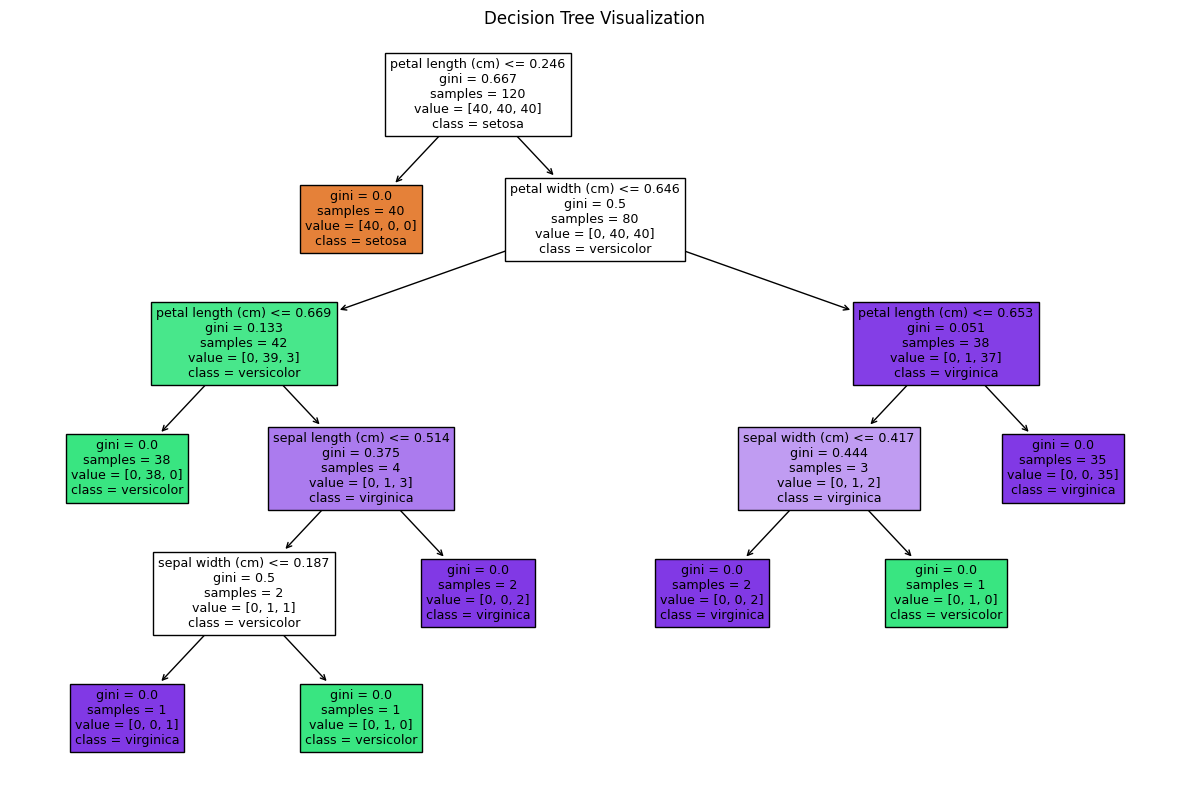

In [16]:
# Part A – Decision Tree classifier, metrics, visualize tree

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt, average="weighted")
recall = recall_score(y_test, y_pred_dt, average="weighted")
f1 = f1_score(y_test, y_pred_dt, average="weighted")

print("Decision Tree Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Visualize Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt_clf, feature_names=X_train.columns, class_names=iris.target_names, filled=True)
plt.title("Decision Tree Visualization")
plt.tight_layout()
plt.savefig("decision_tree_visualization.png")
plt.show()


In [17]:
# Compare with KNN (k=5)

from sklearn.neighbors import KNeighborsClassifier

# Train KNN Classifier with k=5
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_clf.predict(X_test)

# Metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average="weighted")
recall_knn = recall_score(y_test, y_pred_knn, average="weighted")
f1_knn = f1_score(y_test, y_pred_knn, average="weighted")

print("KNN (k=5) Performance:")
print(f"Accuracy : {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall   : {recall_knn:.4f}")
print(f"F1 Score : {f1_knn:.4f}")

# Compare Decision Tree vs KNN
print("\nComparison:")
if accuracy_knn > accuracy:
    print("KNN performed better in terms of accuracy.")
elif accuracy_knn < accuracy:
    print("Decision Tree performed better in terms of accuracy.")
else:
    print("Both models performed equally well in terms of accuracy.")


KNN (k=5) Performance:
Accuracy : 0.9667
Precision: 0.9697
Recall   : 0.9667
F1 Score : 0.9666

Comparison:
KNN performed better in terms of accuracy.


In [18]:
# Part B – Generate synthetic basket data

import pandas as pd
import numpy as np
from faker import Faker

faker = Faker()
np.random.seed(42)

# Define pool of 20 items
items_pool = [
    "milk", "bread", "butter", "cheese", "eggs",
    "apples", "bananas", "oranges", "grapes", "watermelon",
    "chicken", "beef", "fish", "pasta", "rice",
    "tomatoes", "onions", "potatoes", "carrots", "lettuce"
]

# Generate 30 synthetic transactions (3–8 items each)
transactions = []
for _ in range(30):
    num_items = np.random.randint(3, 9)  # basket size between 3 and 8
    basket = list(np.random.choice(items_pool, size=num_items, replace=False))
    transactions.append(basket)

# Convert to one-hot encoded DataFrame for Apriori
all_items = sorted(set(items_pool))
basket_df = pd.DataFrame(0, index=range(len(transactions)), columns=all_items)

for idx, basket in enumerate(transactions):
    for item in basket:
        basket_df.at[idx, item] = 1

print("Sample Transactions (first 5):")
print(transactions[:5])

print("\nOne-Hot Encoded Basket DataFrame (first 5 rows):")
print(basket_df.head())


Sample Transactions (first 5):
[['milk', 'pasta', 'grapes', 'bread', 'tomatoes', 'apples'], ['bread', 'pasta', 'grapes', 'apples'], ['onions', 'apples', 'chicken'], ['eggs', 'butter', 'chicken', 'milk', 'grapes', 'oranges'], ['bread', 'apples', 'butter', 'lettuce', 'cheese', 'onions', 'pasta']]

One-Hot Encoded Basket DataFrame (first 5 rows):
   apples  bananas  beef  bread  butter  carrots  cheese  chicken  eggs  fish  \
0       1        0     0      1       0        0       0        0     0     0   
1       1        0     0      1       0        0       0        0     0     0   
2       1        0     0      0       0        0       0        1     0     0   
3       0        0     0      0       1        0       0        1     1     0   
4       1        0     0      1       1        0       1        0     0     0   

   grapes  lettuce  milk  onions  oranges  pasta  potatoes  rice  tomatoes  \
0       1        0     1       0        0      1         0     0         1   
1       1  

In [20]:
# Apply Apriori, sort by lift, top 5 rules

from mlxtend.frequent_patterns import apriori, association_rules

# Find frequent itemsets with min_support=0.2
frequent_itemsets = apriori(basket_df, min_support=0.2, use_colnames=True)

# Generate association rules with min_confidence=0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort by lift in descending order
rules_sorted = rules.sort_values(by="lift", ascending=False)

# Top 5 rules
top_5_rules = rules_sorted.head(5)

print("Top 5 Association Rules by Lift:")
print(top_5_rules[["antecedents", "consequents", "support", "confidence", "lift"]])


Top 5 Association Rules by Lift:
  antecedents consequents  support  confidence      lift
8  (tomatoes)    (cheese)      0.2    0.666667  1.818182
9    (cheese)  (tomatoes)      0.2    0.545455  1.818182
5   (lettuce)     (bread)      0.2    0.666667  1.666667
6     (bread)   (lettuce)      0.2    0.500000  1.666667
3   (bananas)    (grapes)      0.2    0.666667  1.538462


c:\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
